In [1]:
pip install scikit-plot

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Importando Bibliotecas Necessárias**

In [3]:
import math
import nltk
import scipy
import string
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import randint
from wordcloud import WordCloud
from multiprocessing import Pool
from nltk.corpus import stopwords
from scipy.stats import loguniform

from sklearn.decomposition import PCA
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, \
roc_auc_score, roc_curve, precision_score, recall_score

from IPython.display import display

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Importando Dataset**

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Twitter analise/Tweets.csv', header=0)
df.drop(['selected_text', 'textID'], axis=1, inplace=True)
target = 'sentiment'
df.reset_index(drop=True, inplace=True)
original_df = df.copy(deep=True)
display(df.head())

print('\nO conjunto de dados consiste em {} features e {} amostras.'.format(df.shape[1], df.shape[0]))

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative



O conjunto de dados consiste em 2 features e 27481 amostras.


# **Verificando os tipos de todas as colunas**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


# **Verificando as estatísticas de todas as colunas**

In [7]:
display(df.describe())

,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


# **Pré-processamento de dados**

In [8]:
#Verifica se há elementos vazios
print(df.isnull().sum())

text         1
sentiment    0
dtype: int64


In [9]:
#Descartando os valores nulos
df.dropna(inplace=True)
original_df = df.copy()

In [10]:
#Remoção de linhas duplicadas (se houver)
counter = 0
r,c = original_df.shape

df1 = df.drop_duplicates()
df1.reset_index(drop=True, inplace=True)

if df1.shape==(r,c):
    print('O conjunto de dados não tem duplicatas')
else:
    print(f'Número de duplicatas descartadas/corrigidas ---> {r-df1.shape[0]}')

O conjunto de dados não tem duplicatas


In [11]:
#Filtrando os textos
df = df1.copy()

def preprocessor(text):
    text = text.lower()
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])
    text = ' '.join([PorterStemmer().stem(word) for word in text.split()])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text

for i in tqdm(range(df.shape[0])):
    df.loc[i,'text'] = preprocessor(df['text'][i])

df.head()

100%|██████████| 27480/27480 [01:33<00:00, 293.96it/s]


,text,sentiment
0,id respond go,neutral
1,sooo sad miss san diego,negative
2,boss bulli,negative
3,interview leav alon,negative
4,son whi couldnt put releas alreadi bought,negative


 O texto agora está limpo com a remoção de todas as pontuações, palavras irrelevantes e lematização

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.porter import PorterStemmer
porter=PorterStemmer()
def tokenizer(text):
        return text.split()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

tfidf=TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None,tokenizer=tokenizer_porter,use_idf=True,norm='l2',smooth_idf=True)
y=df[target].values
x=tfidf.fit_transform(df.text)

# **Análise exploratória de dados**

             Distribuição de variável Alvo             


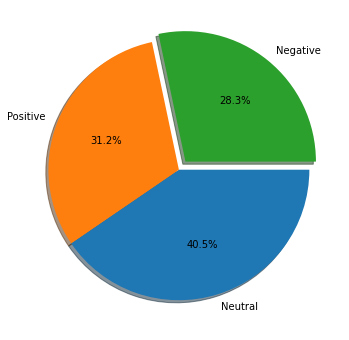

In [13]:
print('Distribuição de variável Alvo'.center(55))
plt.pie(df[target].value_counts(), labels=['Neutral','Positive','Negative'], counterclock=False, shadow=True, 
        explode=[0,0,0.08], autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

100%|██████████| 27480/27480 [00:09<00:00, 2901.13it/s]


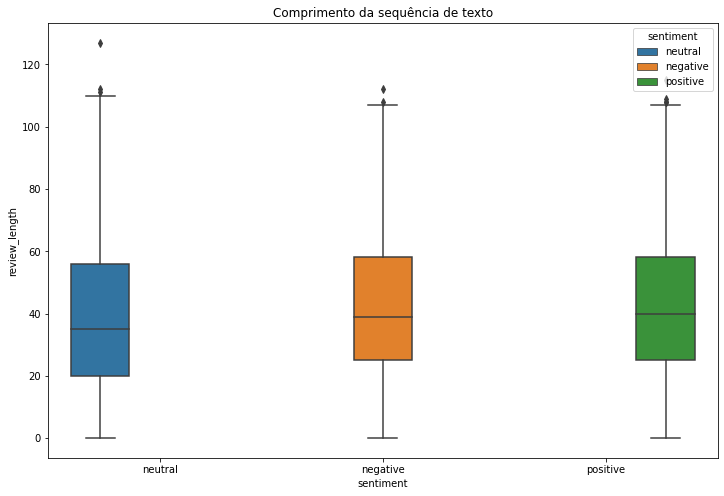

In [14]:
df2 = df.copy()
df2['review_length'] = 0

for i in tqdm(range(df.shape[0])):
    df2['review_length'][i] = len(df2['text'][i])

plt.figure(figsize=[12,8])
sns.boxplot(x=target,y='review_length', data=df2, hue=target)
plt.title('Comprimento da sequência de texto')
plt.show()

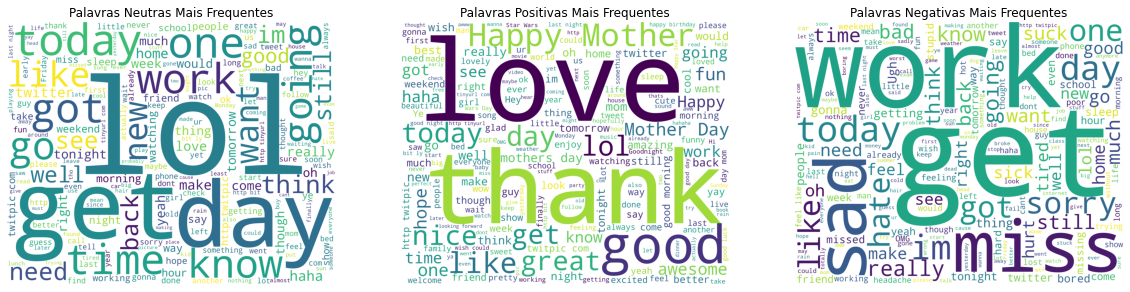

In [15]:
neutraldata = original_df[original_df[target]=='neutral']
neutraldata= neutraldata['text']
positivedata = original_df[original_df[target]=='positive']
positivedata =positivedata['text']
negdata = original_df[original_df[target]== 'negative']
negdata = negdata['text']


def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=stopwords.words('english'),background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,3,1)
wordcloud_draw(neutraldata,'white','Palavras Neutras Mais Frequentes')

plt.subplot(1,3,2)
wordcloud_draw(positivedata,'white','Palavras Positivas Mais Frequentes')

plt.subplot(1,3,3)
wordcloud_draw(negdata, 'white','Palavras Negativas Mais Frequentes')
plt.show()

# **Modelagem Preditiva**

In [16]:
#Atribuindo rótulos à variável de destino
MAP={'negative':0, 'neutral':1, 'positive':2}
df.sentiment = df.sentiment.map(MAP)

In [17]:
#Dividindo os conjuntos de treinamento e teste de introdução de dados
X = x
Y = pd.Series(y).map(MAP)
MAP={'negative':0, 'neutral':1, 'positive':2}
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

print('set Original ---> ',X.shape,len(Y),'\nSet de Treino ---> ',Train_X.shape,len(Train_Y),'\nSet de Teste ---> ', Test_X.shape,'', len(Test_Y))

set Original --->  (27480, 22569) 27480 
Set de Treino --->  (21984, 22569) 21984 
Set de Teste --->  (5496, 22569)  5496


# **Realizar Oversample**

In [18]:
print(Train_X.shape, Train_Y.shape)

(21984, 22569) (21984,)


In [19]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

Train_X, Train_Y = oversample.fit_resample(Train_X, Train_Y)

In [20]:
print(Train_X.shape, Train_Y.shape)

(26526, 22569) (26526,)


In [21]:
#Vamos criar primeiro criar uma tabela para armazenar os resultados de vários modelos
Evaluation_Results = pd.DataFrame(np.zeros((4,5)), columns=['Acuracia', 'Precisão','Recall','F1-score','AUC-ROC'])
Evaluation_Results.index=['Regressão Logistica (RL)','Arvore de Decisão (DT)','Random Forest (RF)','Naïve Bayes (NB)']
Evaluation_Results

,Acuracia,Precisão,Recall,F1-score,AUC-ROC
Regressão Logistica (RL),0.0,0.0,0.0,0.0,0.0
Arvore de Decisão (DT),0.0,0.0,0.0,0.0,0.0
Random Forest (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes (NB),0.0,0.0,0.0,0.0,0.0


In [22]:
#Vamos definir funções para resumir as pontuações da Previsão.
from scikitplot.metrics import plot_roc_curve as auc_roc

#Função Resumo de Classificação
def Classification_Summary(pred,pred_prob,i):
    Evaluation_Results.iloc[i]['Acuracia']=round(accuracy_score(Test_Y, pred),3)*100   
    Evaluation_Results.iloc[i]['Precisão']=round(precision_score(Test_Y, pred, average='weighted'),3)*100 
    Evaluation_Results.iloc[i]['Recall']=round(recall_score(Test_Y, pred, average='weighted'),3)*100 
    Evaluation_Results.iloc[i]['F1-score']=round(f1_score(Test_Y, pred, average='weighted'),3)*100 
    Evaluation_Results.iloc[i]['AUC-ROC']=round(roc_auc_score(Test_Y, pred_prob, multi_class='ovr'),3)*100 
    print('{}{}Avaliando {}  {}{}\n'.format('<'*3,'-'*35,Evaluation_Results.index[i], '-'*35,'>'*3))
    print('Acuracia = {}%'.format(round(accuracy_score(Test_Y, pred),3)*100))
    print('F1 Score = {}%'.format(round(f1_score(Test_Y, pred, average='weighted'),3)*100)) 
    print('\n Matriz de Confusão:\n',confusion_matrix(Test_Y, pred))
    print('\nRelatório de classificação:\n',classification_report(Test_Y, pred))
    
    auc_roc(Test_Y, pred_prob, curves=['each_class'])
    plt.show()

#Função de visualização
def AUC_ROC_plot(Test_Y, pred):    
    ref = [0 for _ in range(len(Test_Y))]
    ref_auc = roc_auc_score(Test_Y, ref)
    lr_auc = roc_auc_score(Test_Y, pred)

    ns_fpr, ns_tpr, _ = roc_curve(Test_Y, ref)
    lr_fpr, lr_tpr, _ = roc_curve(Test_Y, pred)

    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='AUC = {}'.format(round(roc_auc_score(Test_Y, pred)*100,2))) 
    plt.xlabel('Taxa de Falsos Positivos')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.legend()
    plt.show()

<<<-----------------------------------Avaliando Regressão Logistica (RL)  ----------------------------------->>>

Acuracia = 70.0%
F1 Score = 70.0%

 Matriz de Confusão:
 [[ 976  443  104]
 [ 354 1606  315]
 [  84  349 1265]]

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.69      0.64      0.66      1523
           1       0.67      0.71      0.69      2275
           2       0.75      0.74      0.75      1698

    accuracy                           0.70      5496
   macro avg       0.70      0.70      0.70      5496
weighted avg       0.70      0.70      0.70      5496



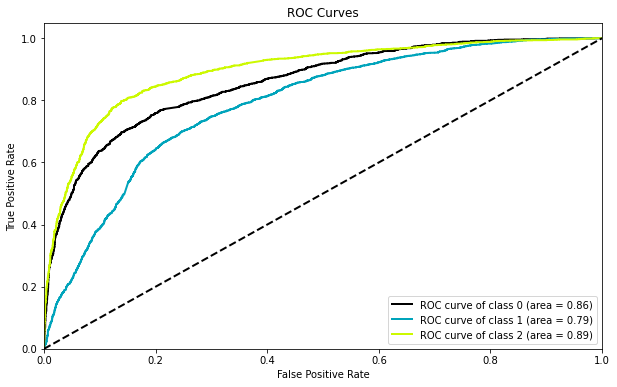

In [23]:
LR_model = LogisticRegression(solver="saga", penalty='l1', multi_class='multinomial', class_weight= 'balanced')
LR = LR_model.fit(Train_X, Train_Y)
pred = LR.predict(Test_X)
pred_prob = LR.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,0)

<<<-----------------------------------Avaliando Arvore de Decisão (DT)  ----------------------------------->>>

Acuracia = 67.80000000000001%
F1 Score = 67.30000000000001%

 Matriz de Confusão:
 [[ 767  576  180]
 [ 240 1693  342]
 [  52  382 1264]]

Relatório de classificação:
               precision    recall  f1-score   support

           0       0.72      0.50      0.59      1523
           1       0.64      0.74      0.69      2275
           2       0.71      0.74      0.73      1698

    accuracy                           0.68      5496
   macro avg       0.69      0.66      0.67      5496
weighted avg       0.68      0.68      0.67      5496



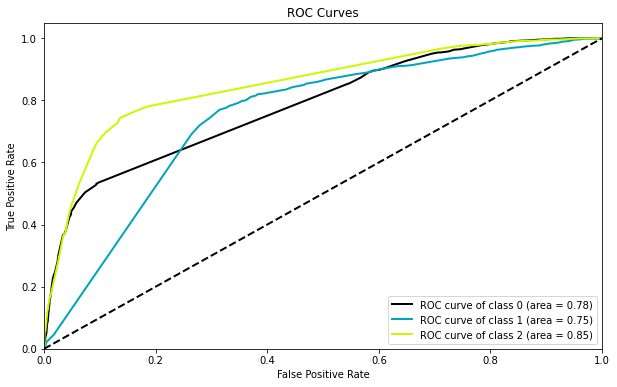

In [24]:
DT_model = DecisionTreeClassifier(criterion="entropy", splitter='random', min_impurity_decrease=0.001, ccp_alpha=0.00001, min_weight_fraction_leaf=0.000001)
DT = DT_model.fit(Train_X, Train_Y)
pred = DT.predict(Test_X)
pred_prob = DT.predict_proba(Test_X)
Classification_Summary(pred,pred_prob,1)

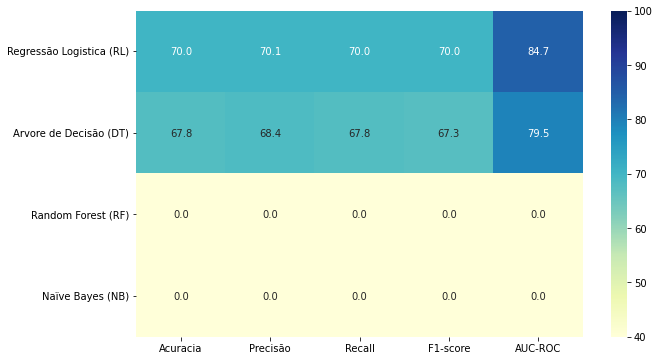

In [25]:
sns.heatmap(Evaluation_Results, annot=True, vmin=40, vmax=100.0, cmap='YlGnBu', fmt='.1f')
plt.show()